In [1]:
import collections
import math
import os
import errno
import random
import zipfile
import numpy as np
from six.moves import urllib
from six.moves import xrange
import tensorflow as tf

## Data

In [2]:
data_dir = "word2vec_data/words/"

In [3]:
data_url = "http://mattmahoney.net/dc/text8.zip"

In [4]:
def fetch_data(url = data_url, words_data = data_dir):
    os.makedirs(words_data, exist_ok=True)
    
    zip_path = os.path.join(words_data, "words.zip")
    
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(url, zip_path)
    
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
        
    return data.decode("ascii").split()

In [5]:
words = fetch_data()

In [6]:
len(words)

17005207

In [7]:
words[10000:10020]

['reciprocity',
 'qualitative',
 'impairments',
 'in',
 'communication',
 'as',
 'manifested',
 'by',
 'at',
 'least',
 'one',
 'of',
 'the',
 'following',
 'delay',
 'in',
 'or',
 'total',
 'lack',
 'of']

In [8]:
for w in words[10000:10020]:
    print(w, end=" ")

reciprocity qualitative impairments in communication as manifested by at least one of the following delay in or total lack of 

## Build Word Counts

In [9]:
from collections import Counter

In [10]:
#mylist = ["one", "two", "two", "four"]

In [11]:
#Counter(mylist)

In [12]:
#Counter(mylist).most_common(1)

# Create Vocab

In [13]:
def create_counts(vocab_size = 50000):
    vocab = [] + Counter(words).most_common(vocab_size)
    
    vocab = np.array([word for word, _ in vocab])
    
    dictionary = {word: code for code, word in enumerate(vocab)}

    data = np.array([dictionary.get(word,0) for word in words])
    return data, vocab

In [14]:
data, vocabulary = create_counts()

In [15]:
data[0]

5233

In [16]:
words[0]

'anarchism'

## Batch Function

In [17]:
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
    if data_index == len(data):
        buffer[:] = data[:span]
        data_index = span
    else:
        buffer.append(data[data_index])
        data_index += 1
  # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

In [18]:
data_index = 0
batch, labels = generate_batch(8, 2, 1)

In [19]:
batch

array([3080, 3080, 3080, 3080, 3080, 3080, 3080, 3080])

In [20]:
labels

array([[  11],
       [5233],
       [5233],
       [  11],
       [5233],
       [  11],
       [  11],
       [5233]])

## Constants and placeholders

In [21]:
batch_size = 128
embedding_size = 150
skip_window = 1
num_skips = 2

In [22]:
valid_size = 16
valid_window = 100
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64
learning_rate = 1.0
vocabulary_size = 50000

In [23]:
tf.reset_default_graph()

# Input data
train_inputs = tf.placeholder(tf.int32, shape=[None])
train_labels = tf.placeholder(tf.int32, shape=[batch_size,1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

## Variables

In [24]:
init_embeds = tf.random_uniform([vocabulary_size, embedding_size], -1.0, -1.0)
embeddings = tf.Variable(init_embeds)

In [25]:
embed = tf.nn.embedding_lookup(embeddings,train_inputs)

In [26]:
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size,embedding_size],
                          stddev=1.0/np.sqrt(embedding_size)))

In [27]:
nce_bias = tf.Variable(tf.zeros([vocabulary_size]))

In [28]:
loss = tf.reduce_mean(tf.nn.nce_loss(nce_weights, nce_bias, train_labels, embed,num_sampled,vocabulary_size))

In [29]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
trainer = optimizer.minimize(loss)

In [30]:
# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [31]:
init = tf.global_variables_initializer()

In [32]:
num_steps = 50000
with tf.Session() as sess:
    sess.run(init)
    average_loss = 0
    for step in range(num_steps):
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict={train_inputs: batch_inputs, train_labels: batch_labels}
        
        empty, loss_val = sess.run([trainer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 1000 == 0:
            if step > 0:
                average_loss /= 1000
            # The average loss is an estimate of the loss over the last 1000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

       

    final_embeddings = normalized_embeddings.eval()        
        

Average loss at step  0 :  280.05914306640625
Average loss at step  1000 :  28753.219839622496
Average loss at step  2000 :  44977.10651569367
Average loss at step  3000 :  51000.712942985534
Average loss at step  4000 :  52447.8720059553
Average loss at step  5000 :  54482.15096151932
Average loss at step  6000 :  48452.24159305001
Average loss at step  7000 :  46936.87846884667
Average loss at step  8000 :  54405.88150004006
Average loss at step  9000 :  52198.434648546216
Average loss at step  10000 :  49985.491294062194
Average loss at step  11000 :  48005.00475574208
Average loss at step  12000 :  54966.07956749344
Average loss at step  13000 :  43334.453199162046
Average loss at step  14000 :  47384.41817430563
Average loss at step  15000 :  52343.87700260735
Average loss at step  16000 :  49053.72683114624
Average loss at step  17000 :  44133.71002616978
Average loss at step  18000 :  43519.97233531189
Average loss at step  19000 :  53669.29743003082
Average loss at step  20000 

## TSNE

In [33]:
final_embeddings.shape

(50000, 150)

In [34]:
from  sklearn.manifold import TSNE
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

In [35]:
plot_only = 5000
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])

In [36]:
labels = [vocabulary[i] for i in range(plot_only)]

In [37]:
low_dim_embs.shape

(5000, 2)

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18,8))
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                    xy=(x, y),
                    xytext=(5, 2),
                    textcoords='offset points',
                    ha= 'right',
                    va= 'bottom')

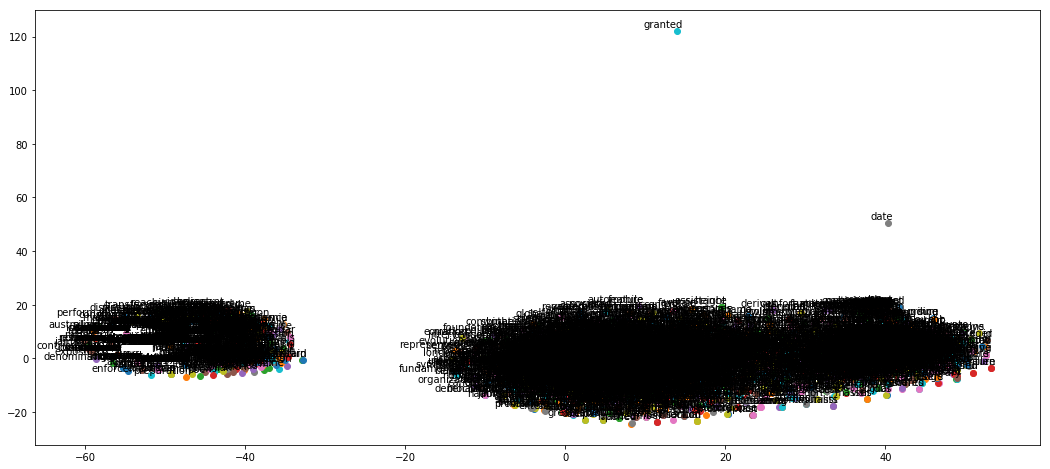

In [40]:
plot_with_labels(low_dim_embs, labels)

(-20, 20)

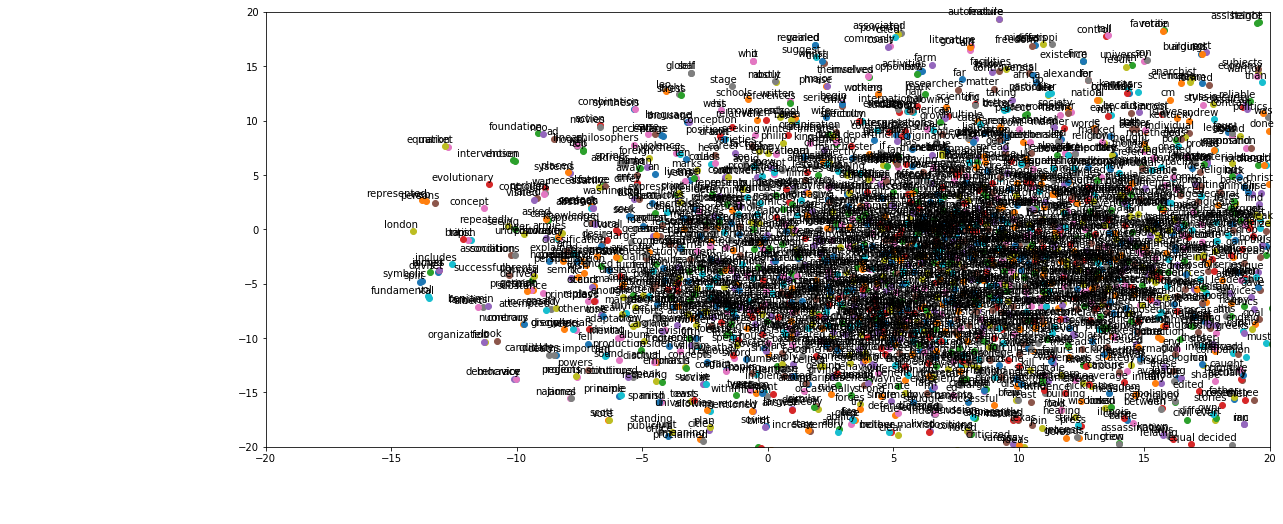

In [42]:
plot_with_labels(low_dim_embs, labels)
plt.xlim(-20,20)
plt.ylim(-20,20)